# Options Chain Column Descriptions

| **Column**          | **Description**                                                                 |
|---------------------|----------------------------------------------------------------------------------|
| `contractSymbol`    | Unique identifier for the option contract (includes ticker, expiration, strike, type). |
| `lastTradeDate`     | Timestamp of the last trade made for that specific option.                      |
| `strike`            | Strike price — the agreed price at which the underlying stock can be bought or sold. |
| `lastOptionPrice`         | Last traded price of the option (may not be current bid/ask).                   |
| `bid`               | Current highest price a buyer is willing to pay for the option.                 |
| `ask`               | Current lowest price a seller is willing to accept for the option.              |
| `change`            | Price change of the option compared to the previous trading day's close.        |
| `percentChange`     | Percentage change in the option's price from the previous close.                |
| `volume`            | Number of option contracts traded during the current trading day.               |
| `openInterest`      | Total number of outstanding option contracts that have not been settled.        |
| `impliedVolatility` | Market's forecast of the stock's future volatility, implied from the option's price. |
| `inTheMoney`        | Boolean — `True` if the option is currently profitable to exercise, else `False`. |
| `contractSize`      | Number of shares per contract (typically 100 for U.S. equity options).          |
| `currency`          | Currency the option is traded in (usually "USD").                               |
| `type`              | `'call'` or `'put'` — you added this manually to distinguish them.              |
| `expiration`        | Expiration date of the option (you also added this manually).                   |


In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import yfinance as yf
import seaborn as sns
import pandas  as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px
from FMNM.BS_pricer import BS_pricer
from FMNM.Parameters import Option_param
from FMNM.Processes import Diffusion_process

import scipy.stats as ss
from scipy.integrate import quad
from typing import List, Optional
from scipy.stats import lognorm
from scipy.stats import norm
from functools import partial

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

from utils.gbm import GBMAnalyzer
from utils.dataFetcher import OptionsDataFetcher as odf

In [21]:
fetcher = odf('TSLA')
stock_data = fetcher.fetch_stock_data("2023-04-18", "2025-05-18")
opts_data = fetcher.fetch_options_chain()
opts_data_p = fetcher.fetch_options_chain(puts_only = True)
opts_data_c = fetcher.fetch_options_chain(calls_only = True)
fetcher.save(stock_data, opts_data, path="retrivedData", save_stock=True, save_options=True)

Stock data saved to: retrivedData/TSLA_stock_data.csv
Options data saved to: retrivedData/TSLA_options_chain.csv


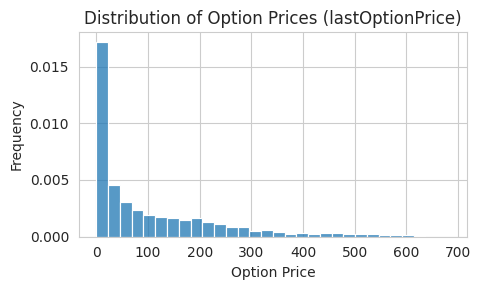

In [22]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 3))
sns.histplot(opts_data['lastOptionPrice'], bins=30, kde=False, edgecolor='white', stat = 'density')
plt.title("Distribution of Option Prices (lastOptionPrice)")
plt.xlabel("Option Price")
plt.ylabel("Frequency")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [23]:
# Calls
fig_calls = px.scatter(
    opts_data_c,
    x='strike',
    y='lastOptionPrice',
    title='Call Options: Strike vs Last Price',
    labels={'strike': 'Strike Price', 'lastOptionPrice': 'Option Price'},
    color_discrete_sequence=['#1f77b4']
)
fig_calls.update_traces(marker=dict(size=6))
fig_calls.update_layout(template='plotly_white')
fig_calls.show()

# Puts
fig_puts = px.scatter(
    opts_data_p,
    x='strike',
    y='lastOptionPrice',
    title='Put Options: Strike vs Last Price',
    labels={'strike': 'Strike Price', 'lastOptionPrice': 'Option Price'},
    color_discrete_sequence=['#d62728']
)
fig_puts.update_traces(marker=dict(size=6))
fig_puts.update_layout(template='plotly_white')
fig_puts.show()

In [24]:
fig = px.scatter(
    opts_data_c,
    x='lastTradeDate',
    y='lastOptionPrice',
    title='Call Options: Last Price vs. Last Trade Date',
    labels={
        'lastTradeDate': 'Last Trade Date',
        'lastOptionsPrice': 'Last Price (USD)'
    },
    template='plotly_white'
)

fig.update_traces(
    marker=dict(size=6, color='skyblue', line=dict(width=1, color='DarkSlateGrey'))
)

fig.update_layout(
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    title_font_size=20
)

fig.show()

In [25]:
fig = go.Figure()

# Scatter for Strike vs. Last Trade Date
fig.add_trace(go.Scatter(
    x=opts_data_c['lastTradeDate'],
    y=opts_data_c['strike'],
    mode='markers',
    name='Strike Price',
    marker=dict(color='#1f77b4', size=6),
))

# Scatter for Last Price vs. Last Trade Date
fig.add_trace(go.Scatter(
    x=opts_data_c['lastTradeDate'],
    y=opts_data_c['lastOptionPrice'],
    mode='markers',
    name='Last Option Price',
    marker=dict(color='#d62728', size=6),
))

fig.update_layout(
    title='Call Options: Strike & Last Price over Time',
    xaxis_title='Last Trade Date',
    yaxis_title='Price',
    template='plotly_white',
    legend=dict(title="Metrics"),
    height=500
)

fig.show()


In [26]:
fig = go.Figure()

# Strike Price trace (blue)
fig.add_trace(go.Scatter(
    x=opts_data_p['lastTradeDate'],
    y=opts_data_p['strike'],
    mode='markers',
    name='Strike Price',
    marker=dict(color='#1f77b4')
))

# Last Price trace (red)
fig.add_trace(go.Scatter(
    x=opts_data_p['lastTradeDate'],
    y=opts_data_p['lastOptionPrice'],
    mode='markers',
    name='Last Option Price',
    marker=dict(color='#d62728')
))

fig.update_layout(
    title='Put Options: Strike & Last Price over Time',
    xaxis_title='Last Trade Date',
    yaxis_title='Price (USD)',
    template='plotly_white',
    legend_title='Metric',
    height=500
)

fig.show()


In [27]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Close'], mode='lines', name='Close'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Open'], mode='lines', name='Open'))

fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Volume'] / 1e6, mode='lines', name='Volume (millions)'))

fig.update_layout(
    title='Stock Prices and Volume',
    xaxis_title='Date',
    yaxis_title='Value',
    template='plotly_white'
)

fig.show()

In [28]:
def plot_greeks(
    data: pd.DataFrame,
    x_col: Optional[str] = None,
    greeks_to_plot: Optional[List[str]] = None,
    title: Optional[str] = "Option Greeks"
) -> None:

    x = data.index if x_col is None else data[x_col]

    available_greeks = [g for g in ['delta', 'gamma', 'theta', 'vega', 'rho'] if g in data.columns]

    greeks = greeks_to_plot if greeks_to_plot is not None else available_greeks

    fig = go.Figure()

    for greek in greeks:
        if greek in data.columns:
            fig.add_trace(
                go.Scatter(
                    x=x,
                    y=data[greek],
                    mode='lines+markers',
                    name=greek.capitalize()
                )
            )

    fig.update_layout(
        title=title,
        xaxis_title=x_col if x_col else "Index",
        yaxis_title="Value",
        template="plotly_white"
    )

    fig.show()


In [29]:
def S(timestamp):
    return stock_data.loc[timestamp, 'Close']

def profit(t0, t, p):
    St, S0 = S(t), S(t0)
    if St > S0:
        print('call!')
    elif St < S0:
        print('put')
    else:
        print('stable')
    return max(np.abs(St - S0) -p , -p)

In [30]:
analyzer = GBMAnalyzer(stock_data)

start_date = "2024-05-15"
end_date = "2025-05-15"

mean_log, std_log = analyzer.gbm_log_stats(start_date, end_date)

print(f"Expected log-price at {end_date}: {mean_log:.4f}")
print(f"Std dev of log-price: {std_log:.4f}")

ci_low, ci_high = analyzer.confidence_interval(start_date, end_date)
print(f"95% Confidence Interval for Price at {end_date}:")
print(f"Lower Bound: ${ci_low:.2f}")
print(f"Upper Bound: ${ci_high:.2f}")

Expected log-price at 2025-05-15: 5.5873
Std dev of log-price: 0.7146
95% Confidence Interval for Price at 2025-05-15:
Lower Bound: $63.95
Upper Bound: $1114.90


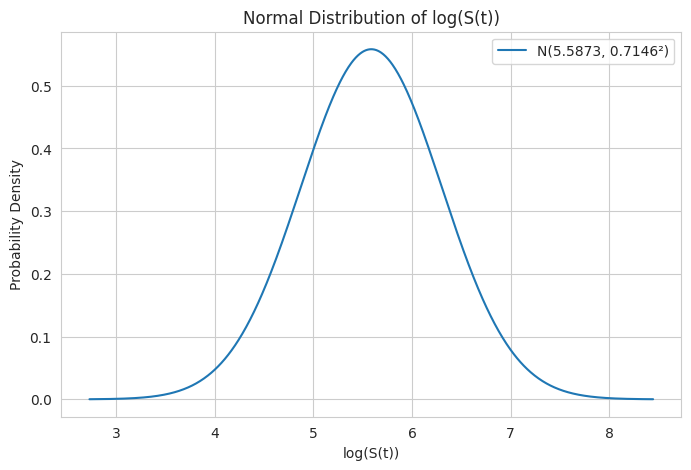

In [31]:
mean, std= mean_log, std_log
x = np.linspace(mean - 4*std, mean + 4*std, 1000)
pdf = norm.pdf(x, loc=mean, scale=std)

plt.figure(figsize=(8,5))
plt.plot(x, pdf, label=f'N({mean:.4f}, {std:.4f}²)')
plt.title('Normal Distribution of log(S(t))')
plt.xlabel('log(S(t))')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

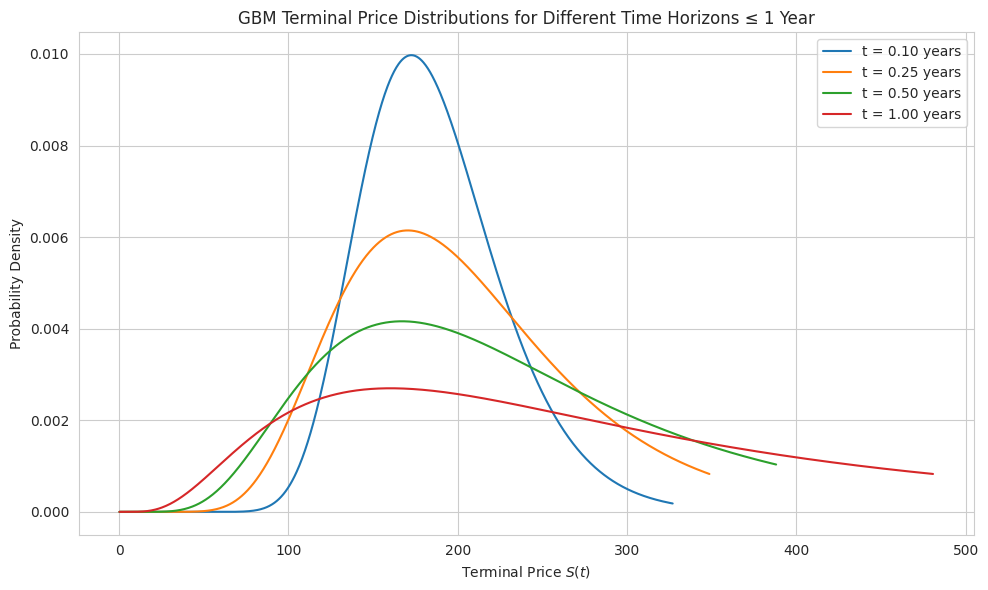

In [32]:

# Time horizons (fractions of 1 year)
time_horizons = [0.1, 0.25, 0.5, 1.0]

plt.figure(figsize=(10, 6))

prices = analyzer._get_prices(start_date, end_date)
S0 = prices[0]

for t in time_horizons:
    analyzer.t = t  # Set time horizon fraction
    
    mu = analyzer.mean_log_s(prices, S0)
    sigma = analyzer.std_log_s(prices)
    
    scale = np.exp(mu)
    s = sigma
    
    x = np.linspace(scale * 0.001, scale * 1.8, 1000)
    pdf = lognorm.pdf(x, s=s, scale=scale)
    
    plt.plot(x, pdf, label=f't = {t:.2f} years')

plt.title('GBM Terminal Price Distributions for Different Time Horizons ≤ 1 Year')
plt.xlabel('Terminal Price $S(t)$')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
df = stock_data['Close'].copy().reset_index()
df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

train_start = '2024-04-18'
train_end   = '2025-02-14'

test_start  = '2024-07-18'
test_end    = '2025-05-14'

train_df = df.loc[train_start:train_end]
test_df  = df.loc[test_start:test_end]

# Optional: reset index if needed
# train_df = train_df.reset_index()
# test_df = test_df.reset_index()


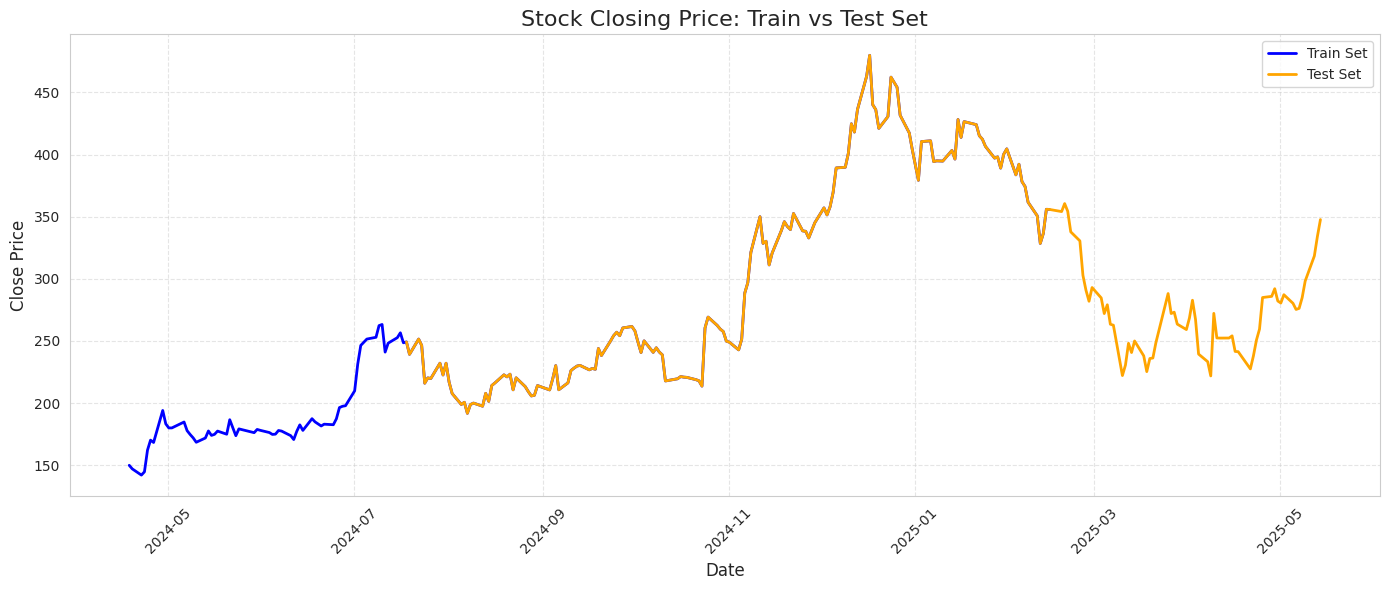

In [34]:


plt.figure(figsize=(14, 6))

# Plot train set
plt.plot(train_df.index, train_df['Close'], label='Train Set', color='blue', linewidth=2)

# Plot test set
plt.plot(test_df.index, test_df['Close'], label='Test Set', color='orange', linewidth=2)

# Title and labels
plt.title('Stock Closing Price: Train vs Test Set', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)

# Format date ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)

# Grid, legend, and layout
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

plt.show()


In [35]:
S0s = np.array(train_df['Close'])
t = 0.25

In [36]:
train_df.shape[0]

208

In [37]:
train_df = train_df.reset_index()

In [38]:
test_df = test_df.reset_index()

In [39]:
ci_lower = []
ci_upper = []
for i in range(train_df.shape[0]-1):

    start_date = train_df['Date'].iloc[i]
    end_date = test_df['Date'].iloc[i]
    
    analyzer = GBMAnalyzer(stock_data, 0.25)
    
    mean_log, std_log = analyzer.gbm_log_stats(start_date, end_date)
    print(std_log)
    ci_low, ci_high = analyzer.confidence_interval(start_date, end_date)
    ci_lower.append(ci_low)
    ci_upper.append(ci_high)
ci_lower.append(0)
ci_upper.append(0)

0.3041424217864506
0.3069460823908819
0.3067359785052034
0.30804887175663265
0.32054636603722464
0.31777547537748474
0.31745391201067835
0.28903658629825696
0.28613810400486295
0.2878803680559512
0.2968483211340977
0.3004649626999728
0.30337662927759457
0.3007432584591097
0.3038819829425388
0.3053441741943373
0.3044571482309714
0.30432049604978845
0.3067974467194606
0.3078709556165823
0.31357515426866145
0.3134104998053886
0.3140499198556402
0.308028477874326
0.30560855167489553
0.3093515350807666
0.31093487330501174
0.31259105790786595
0.313317064013881
0.3136815461772205
0.3136163659539814
0.3152998539618067
0.3157034283283862
0.3180074830585538
0.32087057378971834
0.33407319212999403
0.33397466999682546
0.3357715654200874
0.3340379092121076
0.333096009858329
0.3318234533510399
0.32878321849686826
0.3283284094847481
0.32766915913258415
0.334623074897663
0.3357578671419203
0.33798431909287563
0.33544021503781385
0.33550423309689653
0.3358499833908239
0.33181700844720435
0.317661744410

In [40]:
train_df['ci_lower'] = ci_lower
train_df['ci_upper'] = ci_upper

In [42]:
test_df.shape[0]

207

In [43]:
train_df['mean'] = (train_df['ci_lower'] +  train_df['ci_upper'])/2  

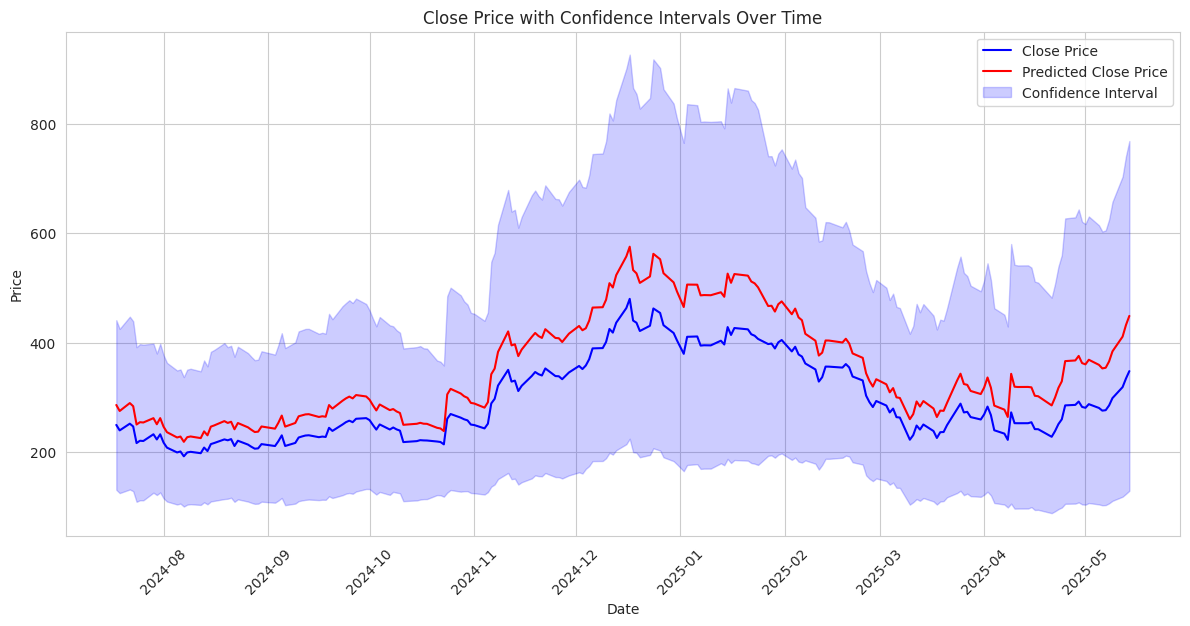

In [44]:
# Plot again
plt.figure(figsize=(12, 6))
plt.plot(test_df["Date"], test_df["Close"], label="Close Price", color="blue")
plt.plot(test_df["Date"], train_df["mean"][:-1], label="Predicted Close Price", color="red")
plt.fill_between(test_df["Date"], train_df["ci_lower"][:-1], train_df["ci_upper"][:-1], color="blue", alpha=0.2, label="Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Close Price with Confidence Intervals Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [58]:
def mu_sig_annual(prices):

    # Step 1: Calculate daily log returns
    log_returns = np.log(prices[1:] / prices[:-1])
    
    # Step 2: Calculate daily mean return and daily volatility
    mu_daily = np.mean(log_returns)
    sigma_daily = np.std(log_returns)
    
    # Step 3: Annualize drift and volatility assuming 252 trading days
    mu = mu_daily * 252
    sigma = sigma_daily * np.sqrt(252)
    return mu, sigma

def drift_term(mu, sigma, t):
    return (mu - 0.5 * sigma**2) * t

def St(S0, mu, sigma, t):
    Z = np.random.normal()  # standard normal random variable
    return S0 * np.exp(drift_term(mu, sigma, t) + sigma * Z * np.sqrt(t))

def predict_prices(prices, t):
    mu, sigma = mu_sig_annual(prices)
    predicted = []
    for S0 in prices:
        predicted_price = St(S0, mu, sigma, t)
        predicted.append(predicted_price)
    return predicted

def split_train_test_equal_len(stock_data, start_date, t, days_in_year=365):
    # Calculate approximate number of trading days for training
    train_days = int(t * days_in_year)

    # Find the train start index
    start_idx = stock_data.index.get_loc(start_date)

    # Define train slice: length train_days from start_idx
    train_data = stock_data.iloc[start_idx : start_idx + train_days]

    # Define test slice: immediately following train slice, same length
    test_data = stock_data.iloc[start_idx + train_days : start_idx + 2 * train_days]

    return train_data, test_data

In [59]:
# #helper
# def date_after_t(start_date, t_years, days_in_year=365):
#     cutoff_days = int(t_years * days_in_year)
#     date_after_t = start_date + pd.Timedelta(days=cutoff_days)
#     weekday = date_after_t.weekday()
#     if weekday >= 5:  # Saturday or Sunday
#         days_to_monday = 7 - weekday
#         date_after_t += pd.Timedelta(days=days_to_monday)
#     return date_after_t

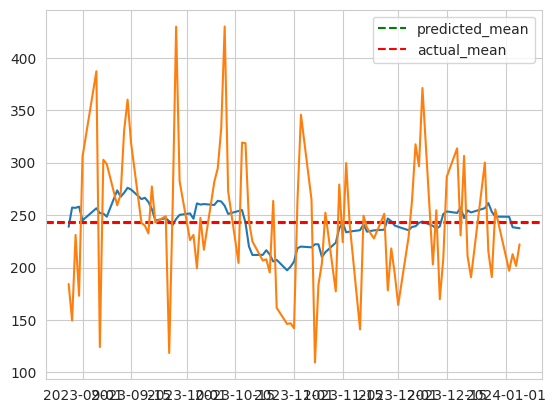

In [64]:
start_date = stock_data.index[0]
train_data, test_data = split_train_test_equal_len(stock_data, start_date , t)
prices = np.array(test_data['Close'])
predicted = predict_prices(prices, t)
plt.plot(test_data.index, test_data['Close'])
plt.axhline(y=np.mean(predicted), color='g', linestyle='--', label='predicted_mean')
plt.axhline(y=np.mean(prices), color='r', linestyle='--',label='actual_mean')
plt.plot(test_data.index, predicted)
plt.legend()
plt.show()

In [52]:
stock_data[(stock_data.index.year == 2024)  & (stock_data.index.month == 9)]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-09-03 00:00:00-04:00,215.259995,219.899994,209.639999,210.600006,76714200,0.0,0.0
2024-09-04 00:00:00-04:00,210.589996,222.220001,210.570007,219.410004,80651800,0.0,0.0
2024-09-05 00:00:00-04:00,223.490005,235.000000,222.250000,230.169998,119355000,0.0,0.0
2024-09-06 00:00:00-04:00,232.600006,233.600006,210.509995,210.729996,112177000,0.0,0.0
2024-09-09 00:00:00-04:00,216.199997,219.869995,213.669998,216.270004,67443500,0.0,0.0
2024-09-10 00:00:00-04:00,220.070007,226.399994,218.639999,226.169998,78891100,0.0,0.0
2024-09-11 00:00:00-04:00,224.550003,228.470001,216.800003,228.130005,83548600,0.0,0.0
2024-09-12 00:00:00-04:00,224.660004,231.449997,223.830002,229.809998,72020000,0.0,0.0
2024-09-13 00:00:00-04:00,228.000000,232.669998,226.320007,230.289993,59515100,0.0,0.0


In [53]:
prices = stock_data[stock_data.index.year >= 2024]

In [55]:
train_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-18 00:00:00-04:00,187.149994,187.690002,183.580002,184.309998,92067000,0.0,0.0
2023-04-19 00:00:00-04:00,179.100006,183.500000,177.649994,180.589996,125732700,0.0,0.0
2023-04-20 00:00:00-04:00,166.169998,169.699997,160.559998,162.990005,210970800,0.0,0.0
2023-04-21 00:00:00-04:00,164.800003,166.000000,161.320007,165.080002,123539000,0.0,0.0
2023-04-24 00:00:00-04:00,164.649994,165.649994,158.610001,162.550003,140006600,0.0,0.0
...,...,...,...,...,...,...,...
2023-07-12 00:00:00-04:00,276.329987,276.519989,271.459991,271.989990,95672100,0.0,0.0
2023-07-13 00:00:00-04:00,274.589996,279.450012,270.600006,277.899994,112681500,0.0,0.0
2023-07-14 00:00:00-04:00,277.010010,285.299988,276.309998,281.380005,119771100,0.0,0.0


In [56]:
test_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-07-19 00:00:00-04:00,296.040009,299.290009,289.519989,291.260010,142355400,0.0,0.0
2023-07-20 00:00:00-04:00,279.559998,280.929993,261.200012,262.899994,175158300,0.0,0.0
2023-07-21 00:00:00-04:00,268.000000,268.000000,255.800003,260.019989,161050100,0.0,0.0
2023-07-24 00:00:00-04:00,255.850006,269.850006,254.119995,269.059998,136508500,0.0,0.0
2023-07-25 00:00:00-04:00,272.380005,272.899994,265.000000,265.279999,112757300,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-10 00:00:00-04:00,257.750000,268.940002,257.649994,263.619995,122656000,0.0,0.0
2023-10-11 00:00:00-04:00,266.200012,268.600006,260.899994,262.989990,103706300,0.0,0.0
2023-10-12 00:00:00-04:00,262.920013,265.410004,256.630005,258.869995,111508100,0.0,0.0


In [57]:
date_after_t(train_data.index[0], 0.25, days_in_year=252)

Timestamp('2023-06-20 00:00:00-0400', tz='America/New_York')